In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import wave
import IPython.display as ipd

Opened audio file 'data/03-01-05-01-01-01-01_A1.wav':
  Channels: 1
  Sample width: 2
  Frame rate: 48000
  Frames: 185786
  Compression type: NONE
  Compression name: not compressed


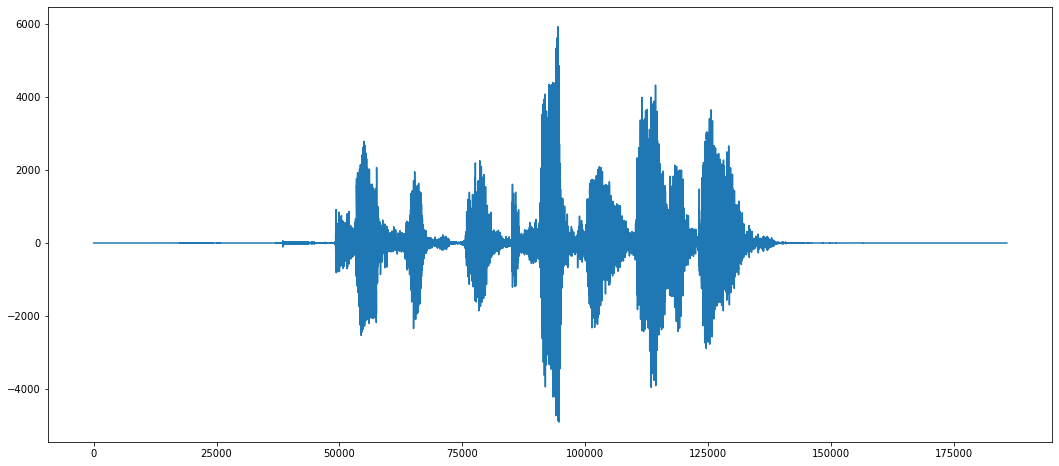

In [27]:
filename = "data/03-01-05-01-01-01-01_A1.wav"

types = {
    1: np.int8,
    2: np.int16,
    4: np.int32
}

audiofile = wave.open(filename, "rb")
signal = np.frombuffer(audiofile.readframes(audiofile.getnframes()), types[audiofile.getsampwidth()])
signal_length = len(signal)

print("Opened audio file '{}':".format(filename))
print("  Channels:", audiofile.getnchannels())
print("  Sample width:", audiofile.getsampwidth())
print("  Frame rate:", audiofile.getframerate())
print("  Frames:", audiofile.getnframes())
print("  Compression type:", audiofile.getcomptype())
print("  Compression name:", audiofile.getcompname())

plt.figure(figsize=(18, 8))
plt.plot(signal)
plt.show()

ipd.Audio(signal, rate=audiofile.getframerate())

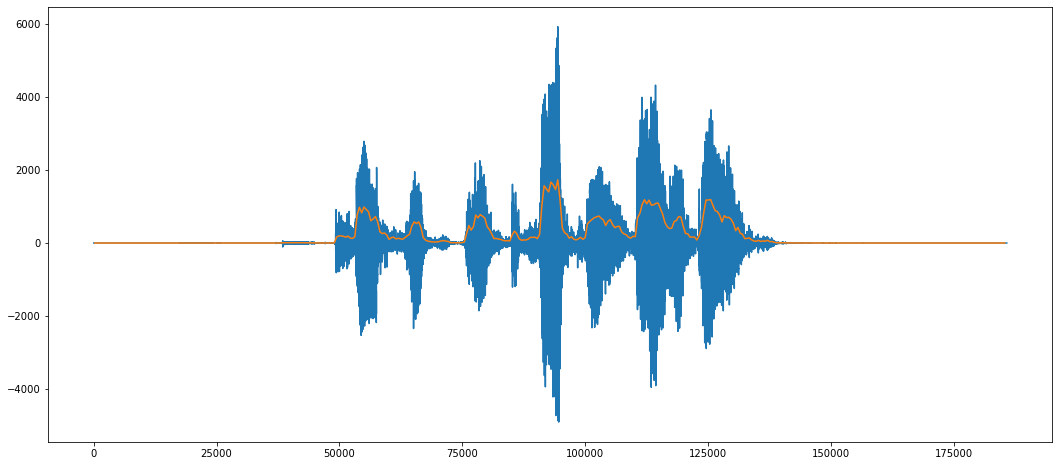

In [28]:
envelope = []
envelope_length = 400
frame_length = signal_length // envelope_length

for j in range(envelope_length):
    s = 0.0
    for k in range(frame_length * j, frame_length * (j + 1)):
        s += np.abs(signal[k])
    envelope.append(s / frame_length)

plt.figure(figsize=(18, 8))
plt.plot(signal)
plt.plot([frame_length * (i + 0.5) for i in range(envelope_length)], envelope)
plt.show()

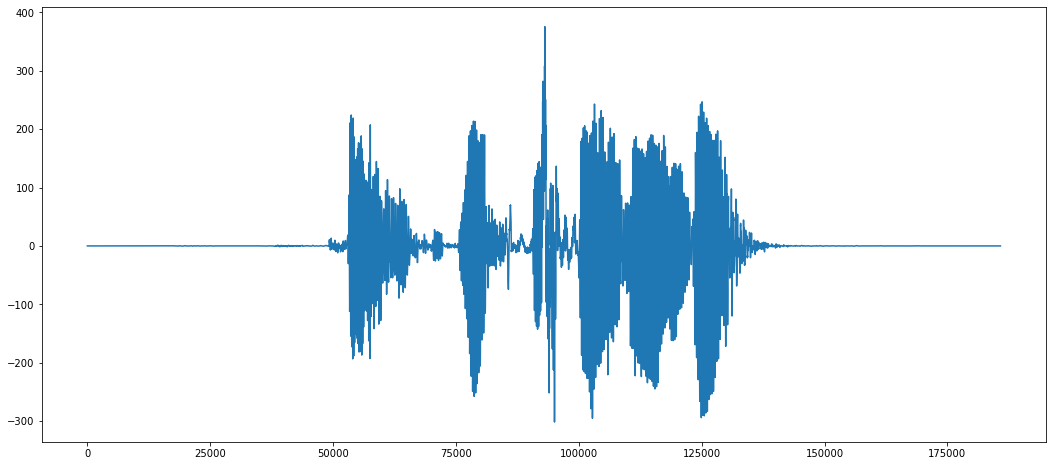

In [33]:
p = 1
fs = 100
wn = 2 * fs / audiofile.getframerate()
b, a = sig.butter(p, wn, "lowpass")
changed_signal = sig.filtfilt(b, a, signal)

plt.figure(figsize=(18, 8))
plt.plot(changed_signal)
plt.show()

ipd.Audio(changed_signal, rate=audiofile.getframerate())

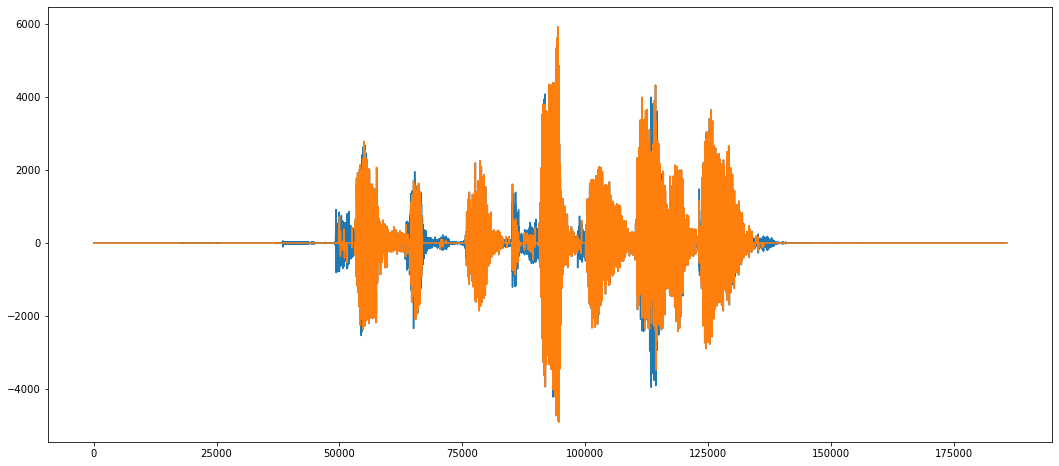

In [48]:
alpha = 0.5
middle_signal = 0.0
k = 10

for i in range(signal_length):
    middle_signal += np.abs(signal[i])

middle_signal /= signal_length
detector_threshold = middle_signal * alpha
detected_signal = [0 for i in range(signal_length)]

detected = False
c1 = 0
c2 = 0
for i in range(signal_length):
    if detected:
        detected_signal[i] = signal[i]
    
    if np.abs(signal[i]) > detector_threshold:
        c1 += 1
        c2 = 0
    else:
        c1 = 0
        c2 += 1
    
    if c1 > k:
        detected = True
    else:
        detected = False    

plt.figure(figsize=(18, 8))
plt.plot(signal)
plt.plot(detected_signal)
plt.show()

ipd.Audio(detected_signal, rate=audiofile.getframerate())

In [ ]:
distance = 15 # m
sound_velocity = 335 # m/s
k = audiofile.getframerate() * distance / 335
applicability = 0.5
delay_lines_length = 8
delay_lines = []
delay_max = []

for i in range(delay_lines_length):
    delay_lines.append(int(input("Введите значение веса линии задержки #{} из {}: ".format(i, delay_lines_length))))
    #delay_max.append(int(input("Введите значение максимальной задержки линии #{} из {}: ".format(i, delay_lines_length))))

d1 = int(input("ented d1: "))
delay_max.append(d1)

for i in range(2, delay_lines_length + 1):
    delay_max.append(2 * (1 - i) / delay_lines_length * d1)

